<a href="https://colab.research.google.com/github/rgrion/mlarrozprevisao/blob/main/Treinamento_Rice_NASA_Clima_South_America_2011_a_2020_3anos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Carregar dataset unificado
df = pd.read_csv("dataset_rice_clima.csv")

# Mostrar primeiras linhas
print("Colunas do dataset:", df.columns.tolist())
df.head()

Colunas do dataset: ['Pais', 'Year', 'Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)', 'Temp_Media_C', 'Precipitacao_mm']


,Pais,Year,Production (t),Area harvested (ha),Yield (kg/ha),Temp_Media_C,Precipitacao_mm
0,Argentina,2011,"1,748,075.00","257,445.00","6,790.10",16.85,22.72
1,Bolivia (Plurinational State of),2011,"428,007.00","178,273.00","2,400.90",25.68,26.22
2,Brazil,2011,"13,476,994.00","2,752,891.00","4,895.60",25.44,79.29
3,Chile,2011,"130,375.00","25,121.00","5,189.90",16.15,6.10
4,Colombia,2011,"2,009,945.00","507,709.00","3,958.90",25.20,115.21


In [ ]:
# === Bloco 2: Preparação do dataset (2011-2020 treino, 2021-2023 previsão) ===

# 1) Ajustar nomes para garantir consistência
df = df.rename(columns={
    'País': 'Area',
    'Pais': 'Area',
    'Ano': 'Year'
})

# 2) Selecionar features e target
# Target será a Produção
target = 'Production (t)'

# Features: área colhida, rendimento e variáveis climáticas
features = [
    'Area harvested (ha)',
    'Yield (kg/ha)',
    'Temp_Media_C',
    'Precipitacao_mm'
]

# 3) Dividir treino e previsão
df_train = df[df['Year'] <= 2020].copy()
df_test = df[df['Year'] > 2020].copy()

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [ ]:
# === Bloco 3: Treinar modelos por país e prever 2021–2023 (com clima) ===
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# 0) Definições
target = 'Production (t)'
feature_cols = ['Year', 'Area harvested (ha)', 'Yield (kg/ha)', 'Temp_Media_C', 'Precipitacao_mm']

# 1) Garantir tipos numéricos nas features/target
for c in feature_cols + [target]:
    if c in df_train.columns:
        df_train[c] = pd.to_numeric(df_train[c], errors='coerce')
    if c in df_test.columns:
        df_test[c] = pd.to_numeric(df_test[c], errors='coerce')

# 2) Remover linhas com NaN nas colunas essenciais
df_train_clean = df_train.dropna(subset=feature_cols + [target]).copy()
df_test_clean  = df_test.dropna(subset=feature_cols + [target]).copy()

# 3) Loop por país
paises = sorted(df_train_clean['Area'].unique())
resultados = []

for pais in paises:
    dftr = df_train_clean[df_train_clean['Area'] == pais]
    dfts = df_test_clean[df_test_clean['Area'] == pais]

    # precisa ter dados de treino e de teste
    if len(dftr) < 2 or dfts.empty:
        continue

    X_tr = dftr[feature_cols].values
    y_tr = dftr[target].values

    X_ts = dfts[feature_cols].values
    y_ts = dfts[target].values
    anos_ts = dfts['Year'].values

    # 3.1) Modelos
    lr  = LinearRegression().fit(X_tr, y_tr)
    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ).fit(X_tr, y_tr)

    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_ts_s = scaler.transform(X_ts)
    svr = SVR(kernel='rbf', C=100, gamma=0.1).fit(X_tr_s, y_tr)

    # 3.2) Previsões vetorizadas (3 anos por país)
    pred_lr  = lr.predict(X_ts)
    pred_xgb = xgb.predict(X_ts)
    pred_svr = svr.predict(X_ts_s)

    # 3.3) Acumular resultados por linha de teste
    for ano, y_real, plr, pxgb, psvr in zip(anos_ts, y_ts, pred_lr, pred_xgb, pred_svr):
        resultados.append({
            'Area': pais,
            'Ano_Previsto': int(ano),
            'Production_Real': float(y_real),
            'Prod_LR': float(plr),
            'Prod_XGB': float(pxgb),
            'Prod_SVR': float(psvr)
        })

# 4) Consolidar e calcular erros
df_resultado = pd.DataFrame(resultados)

for modelo in ['LR', 'XGB', 'SVR']:
    df_resultado[f'Erro_Abs_Prod_{modelo}'] = (df_resultado[f'Prod_{modelo}'] - df_resultado['Production_Real']).abs()
    df_resultado[f'Erro_%_Prod_{modelo}']   = 100 * df_resultado[f'Erro_Abs_Prod_{modelo}'] / df_resultado['Production_Real']

# 5) Exibir amostra e resumo
pd.set_option('display.float_format', '{:,.2f}'.format)
display(df_resultado.sort_values(['Area', 'Ano_Previsto']).head(10))

resumo = pd.DataFrame({
    'MAPE_LR(%)':  [df_resultado['Erro_%_Prod_LR'].mean()],
    'MAPE_XGB(%)': [df_resultado['Erro_%_Prod_XGB'].mean()],
    'MAPE_SVR(%)': [df_resultado['Erro_%_Prod_SVR'].mean()]
}).round(2)

print("Dimensão do resultado:", df_resultado.shape)
display(resumo)

,Area,Ano_Previsto,Production_Real,Prod_LR,Prod_XGB,Prod_SVR,Erro_Abs_Prod_LR,Erro_%_Prod_LR,Erro_Abs_Prod_XGB,Erro_%_Prod_XGB,Erro_Abs_Prod_SVR,Erro_%_Prod_SVR
0,Argentina,2021,"1,453,187.00","1,451,810.17","1,288,514.62","1,481,466.17","1,376.83",0.09,"164,672.38",11.33,"28,279.17",1.95
1,Argentina,2022,"1,222,426.00","1,222,839.89","1,224,220.50","1,481,307.22",413.89,0.03,"1,794.50",0.15,"258,881.22",21.18
2,Argentina,2023,"1,163,209.00","1,155,692.16","1,228,639.75","1,481,400.44","7,516.84",0.65,"65,430.75",5.63,"318,191.44",27.35
3,Bolivia (Plurinational State of),2021,"550,181.52","553,344.99","491,946.59","481,434.26","3,163.47",0.57,"58,234.93",10.58,"68,747.26",12.50
4,Bolivia (Plurinational State of),2022,"608,680.66","614,296.08","515,364.34","481,364.95","5,615.42",0.92,"93,316.32",15.33,"127,315.71",20.92
5,Bolivia (Plurinational State of),2023,"698,543.58","689,094.46","591,185.62","481,318.86","9,449.12",1.35,"107,357.95",15.37,"217,224.72",31.10
6,Brazil,2021,"11,660,605.00","11,672,420.69","11,474,600.00","11,795,445.60","11,815.69",0.10,"186,005.00",1.60,"134,840.60",1.16
7,Brazil,2022,"10,776,268.00","10,814,694.28","11,359,646.00","11,795,382.49","38,426.28",0.36,"583,378.00",5.41,"1,019,114.49",9.46
8,Brazil,2023,"10,285,663.00","10,742,346.56","11,134,026.00","11,795,418.57","456,683.56",4.44,"848,363.00",8.25,"1,509,755.57",14.68
9,Chile,2021,"146,085.10","147,472.61","149,017.66","156,735.10","1,387.51",0.95,"2,932.56",2.01,"10,650.00",7.29


Dimensão do resultado: (36, 12)


,MAPE_LR(%),MAPE_XGB(%),MAPE_SVR(%)
0,2.13,9.14,14.32


In [ ]:
df_resultado

,Area,Ano_Previsto,Production_Real,Prod_LR,Prod_XGB,Prod_SVR,Erro_Abs_Prod_LR,Erro_%_Prod_LR,Erro_Abs_Prod_XGB,Erro_%_Prod_XGB,Erro_Abs_Prod_SVR,Erro_%_Prod_SVR
0,Argentina,2021,"1,453,187.00","1,451,810.17","1,288,514.62","1,481,466.17","1,376.83",0.09,"164,672.38",11.33,"28,279.17",1.95
1,Argentina,2022,"1,222,426.00","1,222,839.89","1,224,220.50","1,481,307.22",413.89,0.03,"1,794.50",0.15,"258,881.22",21.18
2,Argentina,2023,"1,163,209.00","1,155,692.16","1,228,639.75","1,481,400.44","7,516.84",0.65,"65,430.75",5.63,"318,191.44",27.35
3,Bolivia (Plurinational State of),2021,"550,181.52","553,344.99","491,946.59","481,434.26","3,163.47",0.57,"58,234.93",10.58,"68,747.26",12.50
4,Bolivia (Plurinational State of),2022,"608,680.66","614,296.08","515,364.34","481,364.95","5,615.42",0.92,"93,316.32",15.33,"127,315.71",20.92
5,Bolivia (Plurinational State of),2023,"698,543.58","689,094.46","591,185.62","481,318.86","9,449.12",1.35,"107,357.95",15.37,"217,224.72",31.10
6,Brazil,2021,"11,660,605.00","11,672,420.69","11,474,600.00","11,795,445.60","11,815.69",0.10,"186,005.00",1.60,"134,840.60",1.16
7,Brazil,2022,"10,776,268.00","10,814,694.28","11,359,646.00","11,795,382.49","38,426.28",0.36,"583,378.00",5.41,"1,019,114.49",9.46
8,Brazil,2023,"10,285,663.00","10,742,346.56","11,134,026.00","11,795,418.57","456,683.56",4.44,"848,363.00",8.25,"1,509,755.57",14.68
9,Chile,2021,"146,085.10","147,472.61","149,017.66","156,735.10","1,387.51",0.95,"2,932.56",2.01,"10,650.00",7.29


In [ ]:
# Média dos erros percentuais por ano (LR, XGB, SVR)
media_erro_por_ano = (
    df_resultado
    .groupby('Ano_Previsto', as_index=False)[['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']]
    .mean()
    .sort_values('Ano_Previsto')
)

# (opcional) renomear para exibição
tabela_media_erro = media_erro_por_ano.rename(columns={
    'Ano_Previsto': 'Ano',
    'Erro_%_Prod_LR': 'LR (%)',
    'Erro_%_Prod_XGB': 'XGB (%)',
    'Erro_%_Prod_SVR': 'SVR (%)'
})

display(tabela_media_erro.round(2))

,Ano,LR (%),XGB (%),SVR (%)
0,2021,0.76,4.37,8.94
1,2022,3.94,11.65,16.68
2,2023,1.69,11.40,17.36


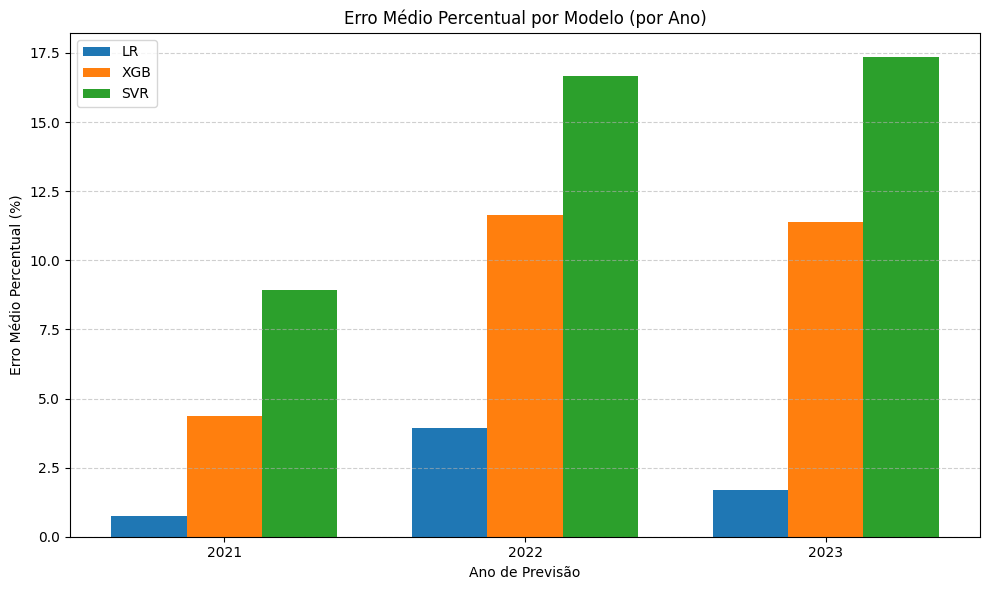

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Garante a existência da tabela de médias
if 'media_erro_por_ano' not in locals():
    media_erro_por_ano = (
        df_resultado
        .groupby('Ano_Previsto', as_index=False)[['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']]
        .mean()
        .sort_values('Ano_Previsto')
    )

plt.figure(figsize=(10, 6))

largura = 0.25
anos = media_erro_por_ano['Ano_Previsto'].values
x = np.arange(len(anos))

plt.bar([p - largura for p in x], media_erro_por_ano['Erro_%_Prod_LR'],  width=largura, label='LR')
plt.bar(x,                          media_erro_por_ano['Erro_%_Prod_XGB'], width=largura, label='XGB')
plt.bar([p + largura for p in x],   media_erro_por_ano['Erro_%_Prod_SVR'], width=largura, label='SVR')

plt.xticks(x, anos)
plt.ylabel('Erro Médio Percentual (%)')
plt.xlabel('Ano de Previsão')
plt.title('Erro Médio Percentual por Modelo (por Ano)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Agrupar por país (coluna 'Area')
media_erro_por_pais = (
    df_resultado
    .groupby("Area")[["Erro_%_Prod_LR", "Erro_%_Prod_XGB", "Erro_%_Prod_SVR"]]
    .mean()
    .reset_index()
)

# Arredondar
media_erro_por_pais = media_erro_por_pais.round(2)

# Exibir tabela no Colab
from google.colab import data_table
data_table.DataTable(media_erro_por_pais, include_index=False, num_rows_per_page=15)

,Area,Erro_%_Prod_LR,Erro_%_Prod_XGB,Erro_%_Prod_SVR
0,Argentina,0.26,5.70,16.83
1,Bolivia (Plurinational State of),0.95,13.76,21.50
2,Brazil,1.63,5.09,8.43
3,Chile,1.80,20.46,35.48
4,Colombia,0.82,1.07,17.90
5,Ecuador,0.15,9.30,4.39
6,Guyana,1.60,8.16,6.41
7,Paraguay,10.25,13.58,17.21
8,Peru,0.17,2.57,9.09
9,Suriname,2.15,16.40,27.79


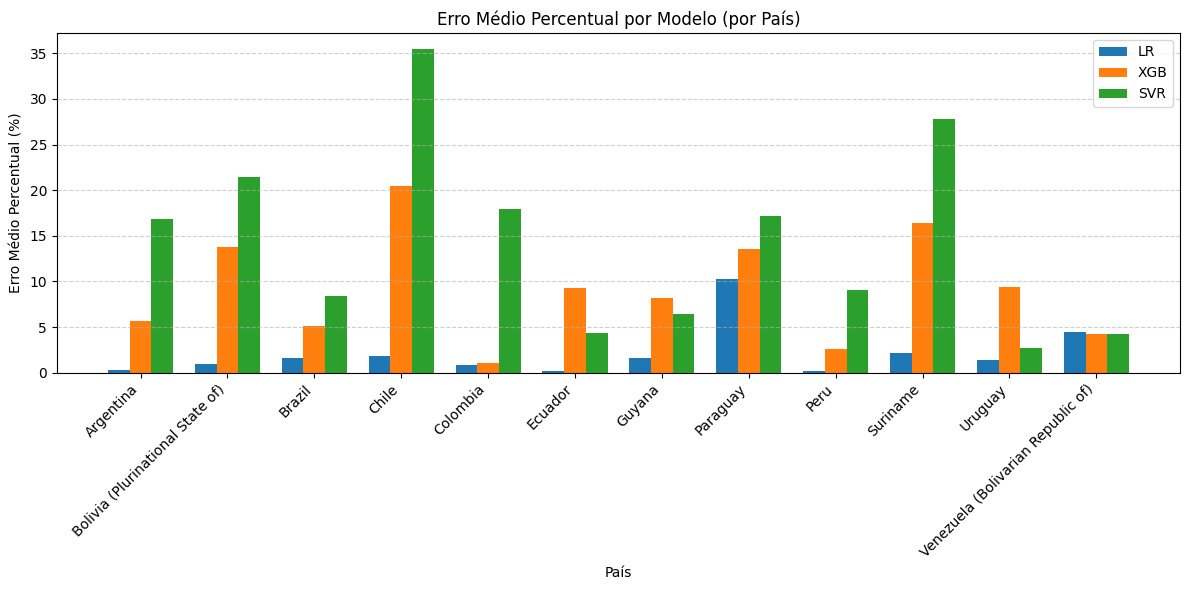

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
paises = media_erro_por_pais["Area"]
x = np.arange(len(paises))
largura = 0.25

plt.figure(figsize=(12, 6))

plt.bar(x - largura, media_erro_por_pais["Erro_%_Prod_LR"], width=largura, label="LR")
plt.bar(x,           media_erro_por_pais["Erro_%_Prod_XGB"], width=largura, label="XGB")
plt.bar(x + largura, media_erro_por_pais["Erro_%_Prod_SVR"], width=largura, label="SVR")

# Layout
plt.xticks(x, paises, rotation=45, ha="right")
plt.ylabel("Erro Médio Percentual (%)")
plt.xlabel("País")
plt.title("Erro Médio Percentual por Modelo (por País)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Definir features (X) e target (y)
X = X_train  # já preparado nos blocos anteriores
y = y_train

# Definir modelos
modelos = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100),
    "SVR": SVR(kernel="rbf")
}

# Validação cruzada
resultados = {}
for nome, modelo in modelos.items():
    scores = cross_val_score(modelo, X, y,
                             cv=5,
                             scoring=make_scorer(mean_absolute_percentage_error))
    resultados[nome] = {
        "MAPE Médio (%)": np.mean(scores) * 100,
        "Desvio Padrão (%)": np.std(scores) * 100
    }

# Converter em DataFrame
df_cv_mape = pd.DataFrame(resultados).T.round(2)

# Mostrar tabela
from google.colab import data_table
data_table.DataTable(df_cv_mape.reset_index().rename(columns={"index": "Modelo"}),
                     include_index=False, num_rows_per_page=10)

,Modelo,MAPE Médio (%),Desvio Padrão (%)
0,Linear Regression,34.63,2.20
1,XGBoost,11.33,3.17
2,SVR,121.15,11.64


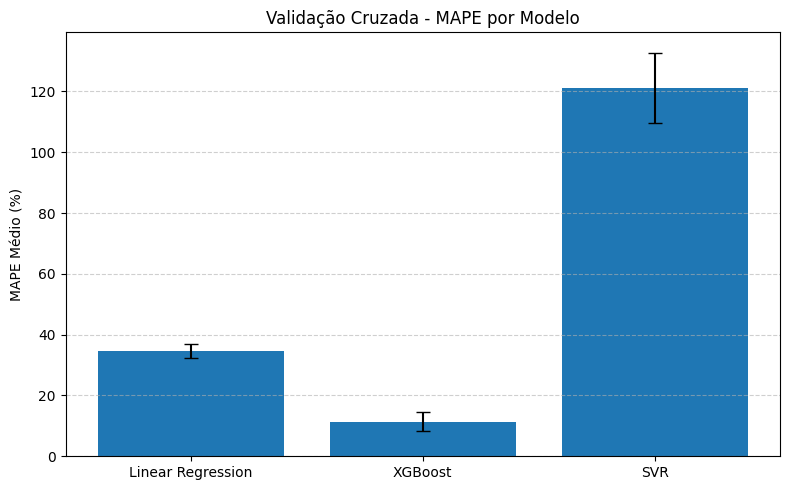

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.bar(df_cv_mape.index, df_cv_mape["MAPE Médio (%)"],
        yerr=df_cv_mape["Desvio Padrão (%)"], capsize=5)

plt.ylabel("MAPE Médio (%)")
plt.title("Validação Cruzada - MAPE por Modelo")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()